# Note
~/.jupyter/jupyter_notebook_config.py　にて、"c.NotebookApp.iopub_data_rate_limit"　変更
 
以下の警告対応: 
 
[W 02:19:13.975 NotebookApp] IOPub data rate exceeded. 
    The notebook server will temporarily stop sending output 
    to the client in order to avoid crashing it. 
    To change this limit, set the config variable 
    `--NotebookApp.iopub_data_rate_limit`. 
[W 02:19:14.464 NotebookApp] iopub messages resumed 


In [14]:
# Motion JPEG Display
# 1. magic command
%matplotlib inline

# 2. import libs
import cv2
from matplotlib import pyplot as plt
import urllib
import numpy as np
## インライン表示
from IPython import display


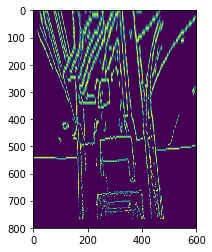

In [23]:
# cap=cv2.VideoCapture('http://128.255.26.210/axis-cgi/mjpg/video.cgi?resolution=352x240')
# https://stackoverflow.com/questions/21702477/how-to-parse-mjpeg-http-stream-from-ip-camera
# mjpgSource=urllib.request.urlopen('http://128.255.26.210/axis-cgi/mjpg/video.cgi?resolution=352x240')
mjpgSource=urllib.request.urlopen('http://192.168.1.233:8080/stream/video.mjpeg')
mjpgBytes = bytes()
isFirstDone=False
mjpgPreview=None

try: 
    while(True):
        # Capture frame-by-frame. ffd8 is start,ffd9 is end of JPEG image.
        # 現時点の受信済バッファ内最後の Frame を処理対象にする。
        mjpgBytes+=mjpgSource.read(512)
        a = mjpgBytes.find(b'\xff\xd8') # ストリーム中の JPEG 画像データ先頭
        b = mjpgBytes.find(b'\xff\xd9') # ストリーム中の JPEG 画像データ末尾
            
        if a!=-1 and b!=-1:
            jpg = mjpgBytes[a:b+2]
            tmpBuf = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
            i=cv2.cvtColor(tmpBuf, cv2.COLOR_BGR2RGB)
            # TopView
            # Part1: Get Transform matrix
            im_height, im_width = i.shape[:2]
            print("w:{0},h:{1}".format(im_width,im_height))

            # これは実測値からの大体の値。4cmx4cmの正方形を写した画像。
            # ここは本来一度計算すればいいが、今回はこのループに入れたままにする。
            T_L=(168,260)
            T_R=(344,260)
            B_R=(408,360)
            B_L=(72,360)
            
            # これを変形する行列を求める
            # まずカメラでとらえた正方形の4点の座標。
            corners = np.array([T_L, T_R, B_R, B_L], dtype="float32")
            # とりあえず、600x800 の画像に　Transform　することにする。
            # 縦横比は正方形ということで1.0、計算省略
            maxWidth, maxHeight = 600, 800
            # Transform 後の正方形の中心は、
            # x は480//2=240
            # y は元の絵の Bottom 328 は、下から32 pix。
            #　また、画面上の正方形の最大幅(下辺)が230であることから、
            # 480-32-115=333　とする
            center_x=maxWidth//2
            center_y=maxHeight-(im_height-L_B[1])-(R_B[0] - L_B[0])//2
            # trScale は変形後の正方形の1辺の長さの半分、やはり1辺230ということで230に。
            trScale=(R_B[0] - L_B[0])//2

            dst = np.array([
            [center_x - trScale, center_y - trScale], #top left
            [center_x + trScale, center_y - trScale], #top right
            [center_x + trScale, center_y + trScale], #bottom right
            [center_x - trScale, center_y + trScale], #bottom left
            ], dtype = "float32")            
            
            # 変換マトリクスの取得
            M = cv2.getPerspectiveTransform(corners, dst)
            
            # Part2: Get Canny Image
            # Part2: Cut upper half of image then get gray
            # half_img=i[im_height//2:im_height,0:im_width]
            # gray=cv2.cvtColor(half_img, cv2.COLOR_BGR2GRAY)
            gray=cv2.cvtColor(i, cv2.COLOR_BGR2GRAY)
            edges=cv2.Canny(gray,15,25)
            
            # Part3: Apply
            warped =  cv2.warpPerspective(edges, M, (maxWidth, maxHeight))
            
            i_display=warped
            
            # Display
            if not isFirstDone:
                # 最初のフレーム処理
                mjpgPreview=plt.imshow(i_display)
                isFirstDone=True
            else:
                # 2フレーム目以降のフレーム処理
                mjpgPreview.set_data(i_display)
                plt.draw()
                display.clear_output(wait=True)
                display.display(plt.gcf())

            # 処理済のデータを捨てます(frame)
            mjpgBytes= mjpgBytes[b+2:]

#　Video を止めるには、"Kernel"|"Interrupt"
except KeyboardInterrupt: 
    mjpgSource.close()
    pass


In [13]:
L_B=(80,328)
L_B[1]
    

328